In [ ]:
import sys, os, re; sys.path = (["../src/", "../"] if re.match(r'^(\w\:\\)|(/)', os.getcwd()) else [])+ sys.path 
from typing import List, Tuple, Dict, Optional, Union

import qubx
%qubxd dev

%load_ext autoreload
%autoreload 2
from qubx import lookup
from qubx.core.basics import Position, ZERO_COSTS, TransactionCostsCalculator
from qubx.core.strategy import Instrument
from qubx.core.series import TimeSeries, OHLCV, time_as_nsec, Quote, Trade

import tests.qube.ta.utils_for_testing as test
from dataclasses import dataclass

In [ ]:
from qubx.core.series import TimeSeries; from qubx.ta.indicators import sma; del sys.modules['qubx.core.series']; del sys.modules['qubx.ta.indicators']
from qubx.core.series import TimeSeries, OHLCV, time_as_nsec, Quote, Trade
from qubx.ta.indicators import (sma, ema, tema, dema, kama, highest, lowest)
from qubx.core.basics import Position, ZERO_COSTS, TransactionCostsCalculator

# Position

In [102]:
pos_round = lambda s, p, i: (p * round(s/p, i.size_precision), p, round(s/p, i.size_precision))
F, S = lambda q, o, c: q/o*(c-o), lambda q, o, c: q*(c-o)

@dataclass
class Deal:
    time: int
    position: int
    exec_price: float
    aggr: bool
    def __init__(self, time, pos, price, agressive=True):
        self.time = time_as_nsec(time)
        self.position = pos
        self.exec_price = price
        self.aggr = agressive

def run_deals_updates(p: Position, qs: List[Union[Deal, Trade, Quote]]) -> dict:
    pnls = {}
    for q in qs:
        if isinstance(q, Deal): 
            pnls[pd.Timestamp(q.time, unit='ns')] = p.update_position(q.time, q.position, q.exec_price, aggressive=q.aggr)
            print(p, f'\t<-(exec -> {q.position})-')
        else: 
            pnls[pd.Timestamp(q.time, unit='ns')] = p.update_market_price(q); print(p)
    return pd.Series(pnls)

In [132]:
tcc = TransactionCostsCalculator(0.04/100, 0.04/100)
i, s = lookup['BINANCE:BTCUSDT'][0], 100/45000
# i, s = lookup['BINANCE.UM:BTCUSDT'][0], 100
# i, s = lookup['BINANCE.CM:BTCUSD_PERP'][0], 1
D = '2024-01-01 '; qs = [
    Quote(D+'12:00:00', 45000, 45000, 100, 50),
    Deal( D+'12:00:30', s, 45010),
    Trade(D+'12:01:00', 45010, 10, 1),
    Trade(D+'12:02:00', 45015, 10, 1),
    Deal( D+'12:02:30', -s, 45015),
    Quote(D+'12:03:00', 45020, 45020, 0, 0),
    Deal( D+'12:03:30', -2*s, 45020),
    Quote(D+'12:04:00', 45120, 45121, 0, 0),
    Quote(D+'12:05:00', 45014, 45014, 0, 0),
    Deal( D+'12:06:30', 0, 45010),
    Quote(D+'12:10:00', 45020, 45020, 0, 0),
    Deal( D+'12:11:00', -s, 45020),
    Quote(D+'12:12:00', 45030, 45030, 0, 0),
    Deal( D+'12:13:00', 0, 45100),
]

In [133]:
p = Position(i, tcc)
run_deals_updates(p, qs)
print(p.commissions, p.pnl)

2024-01-01 12:00:00 [BINANCE:BTCUSDT]       0.00000      0.00    +0.0000 | 45000.00        0.00
2024-01-01 12:00:30 [BINANCE:BTCUSDT]       0.00222  45010.00    +0.0000 | 45010.00      100.02 	<-(exec -> 0.0022222222222222222)-
2024-01-01 12:01:00 [BINANCE:BTCUSDT]       0.00222  45010.00    +0.0000 | 45010.00      100.02
2024-01-01 12:02:00 [BINANCE:BTCUSDT]       0.00222  45010.00    +0.0111 | 45015.00      100.03
2024-01-01 12:02:30 [BINANCE:BTCUSDT]      -0.00222  45015.00    +0.0111 | 45015.00     -100.03 	<-(exec -> -0.0022222222222222222)-
2024-01-01 12:03:00 [BINANCE:BTCUSDT]      -0.00222  45015.00    +0.0000 | 45020.00     -100.04
2024-01-01 12:03:30 [BINANCE:BTCUSDT]      -0.00444  45017.50    +0.0000 | 45020.00     -200.09 	<-(exec -> -0.0044444444444444444)-
2024-01-01 12:04:00 [BINANCE:BTCUSDT]      -0.00444  45017.50    -0.4489 | 45121.00     -200.54
2024-01-01 12:05:00 [BINANCE:BTCUSDT]      -0.00444  45017.50    +0.0267 | 45014.00     -200.06
2024-01-01 12:06:30 [BINAN

### Double Trouble

In [89]:
px1 = Position(i, ZERO_COSTS)

run_deals_updates(px1, [
    Deal( D+'12:00:00', 1000/45000.0, 45000.0),
    Deal( D+'12:01:00', 1000/45000.0 + 1000/46000.0, 46000.0),
    Deal( D+'12:03:00', 0, 47000.0),
    Trade( D+'12:04:00', 47000.0, 0),
    Trade( D+'12:06:00', 48000.0, 0),
])
px1.total_pnl(), F(1000.0, 45000.0, 47000.0) + F(1000.0, 46000.0, 47000.0) 

2024-01-01 12:00:00 [BINANCE:BTCUSDT]       0.02222  45000.00    +0.0000 | 45000.00     1000.00 	<-(exec -> 0.022222222222222223)-
2024-01-01 12:01:00 [BINANCE:BTCUSDT]       0.04396  45494.51   +22.2222 | 46000.00     2022.22 	<-(exec -> 0.043961352657004835)-
2024-01-01 12:03:00 [BINANCE:BTCUSDT]       0.00000      0.00   +66.1836 | 47000.00        0.00 	<-(exec -> 0)-
2024-01-01 12:04:00 [BINANCE:BTCUSDT]       0.00000      0.00   +66.1836 | 47000.00        0.00
2024-01-01 12:06:00 [BINANCE:BTCUSDT]       0.00000      0.00   +66.1836 | 48000.00        0.00


(66.18357487922738, 66.18357487922705)

In [90]:
px1 = Position(i, ZERO_COSTS)
px2 = Position(i, ZERO_COSTS)
run_deals_updates(px1, [
    Deal( D+'12:00:00', 100/45000, 45000),
    Deal( D+'12:03:00', 0, 47000),
])
run_deals_updates(px2, [
    Deal( D+'12:01:00', 100/46000, 46000),
    Deal( D+'12:03:00', 0, 47000),
])
px1.total_pnl() + px2.total_pnl()

2024-01-01 12:00:00 [BINANCE:BTCUSDT]       0.00222  45000.00    +0.0000 | 45000.00      100.00 	<-(exec -> 0.0022222222222222222)-
2024-01-01 12:03:00 [BINANCE:BTCUSDT]       0.00000      0.00    +4.4444 | 47000.00        0.00 	<-(exec -> 0)-
2024-01-01 12:01:00 [BINANCE:BTCUSDT]       0.00217  46000.00    +0.0000 | 46000.00      100.00 	<-(exec -> 0.002173913043478261)-
2024-01-01 12:03:00 [BINANCE:BTCUSDT]       0.00000      0.00    +2.1739 | 47000.00        0.00 	<-(exec -> 0)-


6.618357487922705

### Example from live

<!-- 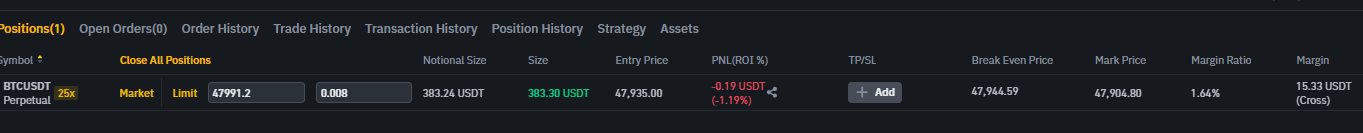 -->
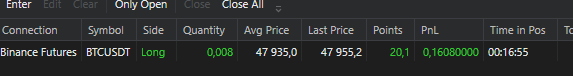
<!-- 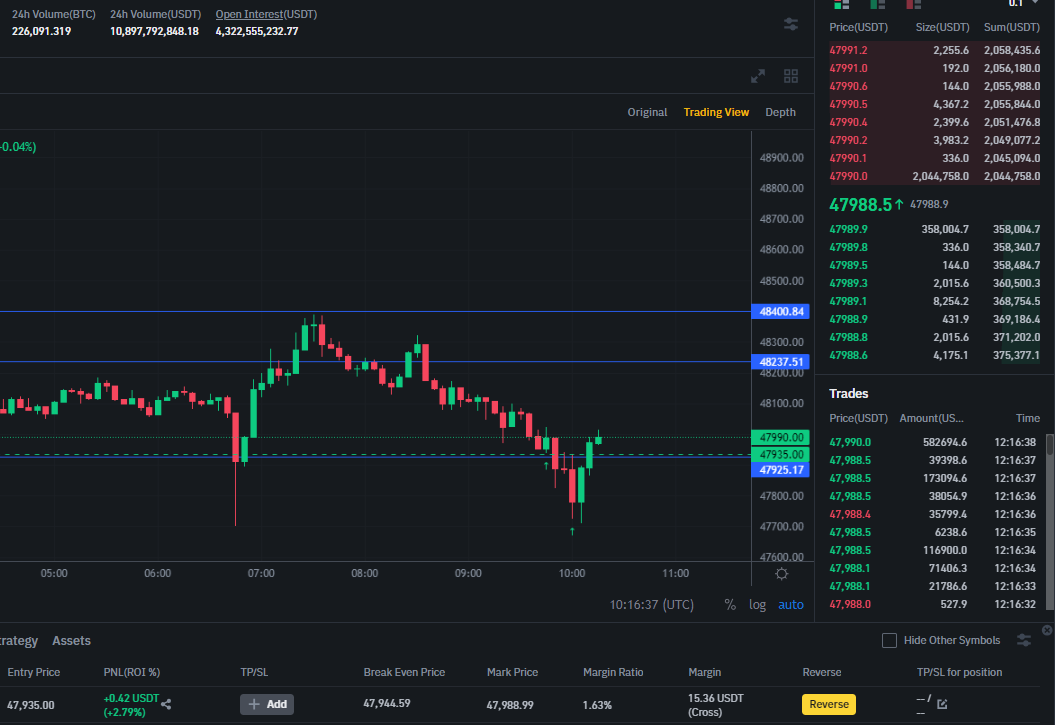 -->
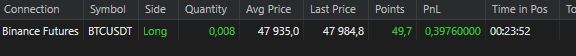
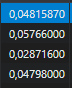

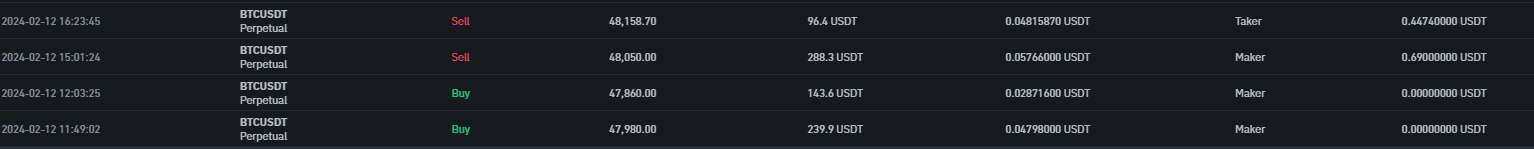

In [134]:
fi = lookup['BINANCE.UM:BTCUSDT'][0]
pf = Position(fi, TransactionCostsCalculator(0.02/100, 0.05/100))
q1 = pos_round(239.9, 47980, fi)[2]
q2 = q1 + pos_round(143.6, 47860, fi)[2]
q3 = q2 - pos_round(300, 48050, fi)[2]
run_deals_updates(pf, [
    Deal(D+'00:00', q1, 47980, False),
    Deal(D+'00:10', q2, 47860, False),
    Trade(D+'00:15', 47984.7, 1),
    Deal(D+'00:20', q3, 48050, False),
    Deal(D+'00:30', 0, 48158.7, True),
])

2024-01-01 00:00:00 [BINANCE.UM:BTCUSDT]       0.005   47980.0    +0.0000 | 47980.0      239.90 	<-(exec -> 0.005)-
2024-01-01 00:10:00 [BINANCE.UM:BTCUSDT]       0.008   47935.0    -0.6000 | 47860.0      382.88 	<-(exec -> 0.008)-
2024-01-01 00:15:00 [BINANCE.UM:BTCUSDT]       0.008   47935.0    +0.3976 | 47984.7      383.88
2024-01-01 00:20:00 [BINANCE.UM:BTCUSDT]       0.002   47935.0    +0.9200 | 48050.0       96.10 	<-(exec -> 0.002)-
2024-01-01 00:30:00 [BINANCE.UM:BTCUSDT]       0.000       0.0    +1.1374 | 48158.7        0.00 	<-(exec -> 0)-


2024-01-01 00:00:00    0.0000
2024-01-01 00:10:00    0.0000
2024-01-01 00:15:00    0.3976
2024-01-01 00:20:00    0.6900
2024-01-01 00:30:00    0.4474
dtype: float64

In [136]:
pf.commissions, (0.04815870 + 0.05766 + 0.028716 + 0.04798)

(0.18251470000000003, 0.1825147)

#### Misc 

In [91]:
class PnLSpot:
    def __init__(self, is_futures=False):
        self.quantity = 0
        self.cost = 0.0
        self.market_value = 0.0
        self.r_pnl = 0.0
        self.average_price = 0.0
        self.is_futures = is_futures
        if is_futures:
            self.fill = self.fill_fu
            self.update = self.update_fu

    def total_pnl(self): return self.r_pnl + (self.market_value - self.cost)

    def fill_fu(self, new_pos, exec_price):
        deal_pnl = 0
        pos_change = new_pos - self.quantity
        direction, prev_direction = np.sign(pos_change), np.sign(self.quantity)
        q_closing = min(abs(self.quantity), abs(pos_change)) * direction if prev_direction != direction else 0
        q_opening = pos_change if prev_direction == direction else pos_change - q_closing

        new_cost = self.cost + q_opening * exec_price
        if self.quantity != 0:
            average_price = self.cost / self.quantity
            new_cost += q_closing * average_price 
            deal_pnl = q_closing * (average_price - exec_price)
            self.average_price = average_price
            # deal_pnl /= average_price

        self.quantity = new_pos
        self.cost = new_cost
        self.r_pnl += deal_pnl
        return self.update(exec_price)

    def update_fu(self, price):
        if self.quantity != 0:
            self.average_price = self.cost / self.quantity
        else: 
            self.average_price = 0

        self.market_value = self.quantity * price
        pnl = self.market_value - self.cost
       
        if self.average_price != 0.0:
            pnl /= self.average_price

        # if self.is_futures and self.average_price != 0.0:
            # pnl /= self.average_price

        # pnl = _qty_in_base * (self.market_value - self.cost)

        print(f"{self.quantity:+8.2f} || PNL: {pnl:8.3f} | R_pnl: {self.r_pnl} | avg_px: {self.average_price}")
        return pnl

    def fill(self, new_pos, exec_price):
        deal_pnl = 0
        pos_change = new_pos - self.quantity
        direction, prev_direction = np.sign(pos_change), np.sign(self.quantity)
        q_closing = min(abs(self.quantity), abs(pos_change)) * direction if prev_direction != direction else 0
        q_opening = pos_change if prev_direction == direction else pos_change - q_closing

        new_cost = self.cost + q_opening * exec_price
        if self.quantity != 0:
            average_price = self.cost / self.quantity
            new_cost += q_closing * average_price 
            deal_pnl = q_closing * (average_price - exec_price)
            if self.is_futures:
                deal_pnl /= average_price
            self.average_price = average_price

        self.quantity = new_pos
        self.cost = new_cost
        self.r_pnl += deal_pnl
        return self.update(exec_price)

    def update(self, price):
        if self.quantity != 0:
            self.average_price = self.cost / self.quantity
        else: 
            self.average_price = 0

        self.market_value = self.quantity * price

        pnl = self.market_value - self.cost

        if self.is_futures and self.average_price != 0.0:
            pnl /= self.average_price

        # pnl = _qty_in_base * (self.market_value - self.cost)

        print(f"{self.quantity:+8.2f} || PNL: {pnl:8.3f} | R_pnl: {self.r_pnl} | avg_px: {self.average_price}")
        return pnl
px = PnLSpot(is_futures=1)
px.fill(100/45000, 45000);  #px.update(46000)
px.fill(200/46000, 46000);  #px.update(47000)
# px.fill(-100, 47000); #px.update(46000)
# px.fill(0, 45000)
px.fill(0, 47000)
px.total_pnl(), F(100, 45000, 47000) + F(100, 46000, 47000) #+ F(-100, 47000, 45000)

   +0.00 || PNL:    0.000 | R_pnl: 0.0 | avg_px: 45000.0
   +0.00 || PNL:    0.000 | R_pnl: 0.0 | avg_px: 45488.88888888889
   +0.00 || PNL:    0.000 | R_pnl: 6.570048309178737 | avg_px: 0


(6.570048309178765, 6.618357487922705)

# Strategy high level design